# **Clustering -- Agglomerative Algorithm**

## **PHASE OF THE CRISP-DM: BUSINESS UNDERSTANDING**

O problema consiste em agrupar os dados (pontos) com base na sua geolocalização (latitude e longitude) e respeitando as restrições.

Restrição:

1) Distância máxima de 1.6 km entre os pontos e seu centróide.

## **PHASE OF THE CRISP-DM: DATA UNDERSTANDING**

Nesta etapa foi realizada a análise exploratória da base. Foi verificado como o dataset é apresentado, suas dimensões e a presença ou não de valores ausentes.

In [26]:
# para os dados
import numpy as np
import pandas as pd
import math

# para a análise geoespacial
import folium

# para machine learning
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestCentroid

In [27]:
# Leitura dos dados
dtf = pd.read_excel('dataset_geo2.xlsx')
dtf.head(5)

,Latitude,Longitude
0,-7.78417,-34.906820
1,-7.94198,-34.897218
2,-7.57838,-35.032610
3,-7.97718,-34.900890
4,-7.56779,-35.005590


In [28]:
# Verificação das dimensões do dataset
print("Apresentando a dimensão dos dados: {}".format(dtf.shape))

# Verificação dos valores ausentes na base
print("Quantidade de valores ausentes:")
print(dtf.isnull().sum())

Apresentando a dimensão dos dados: (4814, 2)
Quantidade de valores ausentes:
Latitude     0
Longitude    0
dtype: int64


A partir dos dados acima, pode verificar que a base contém 4814 instâncias e 2 atributos. Além disso, a base não tem valores ausentes. 

## **PHASE OF THE CRISP-DM: DATA PREPARATION**

Nesta etapa foi realizada a preparação da base de dados. Assim, os pontos (coordenadas de latitude e longitude) foram plotados no mapa utilizando o pacote folium que permite traçar mapas iterativos.

In [29]:
# Definição das variáveis como a latitude e longitude do dataset
x, y = 'Latitude', 'Longitude'

# Fazendo uma cópia do dataframe
data = dtf.copy()

# Definindo o local de inicialização do mapa como a primeira linha do df
loc = data.iloc[0]

# Inicializa o mapa com o local de partida
map_ = folium.Map(location=loc, tiles='cartodbpositron', zoom_start=11)

# Adiciona um círculo no mapa para cada coordenada de latitude e longitude do dataset
data.apply(lambda row: folium.CircleMarker(location=[row[x],row[y]],fill=True,
                                           popup = folium.Popup(str(['LAT',row[x],'LONG',row[y]]))).add_to(map_), axis=1)

# Plotagem do Mapa
map_

Output hidden; open in https://colab.research.google.com to view.

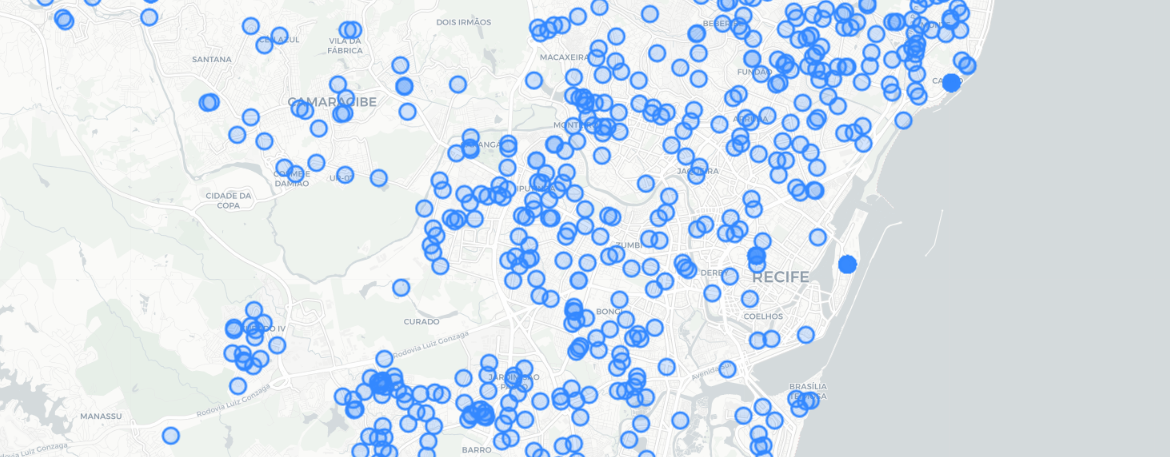

## **PHASE OF THE CRISP-DM: MODELING**

Nesta etapa foi realizado o agrupamento de modo a encontrar os grupos de pontos próximos e seus centróides respeitando a restrição de 1,6 km. O algoritmo aglomerativo hierárquico foi utilizado.

**CLUSTERING - ALGORITMO: AGLOMERATIVO HIERÁRQUICO**

Este algoritmo considera inicialmente cada ponto como um cluster e faz a ligação dos clusters de acordo com a distância entre si. Foi considerada uma distância máxima de 1.6 km entre os pontos.

In [30]:
# Definição da distância máxima (em km) que os pontos podem estar entre si para serem considerados um cluster
d=1.6

# Conversão da distância máxima (d) para radianos
kms_per_radian = 6371.0088
epsilon = d / kms_per_radian #(em radianos) 

# Conversão da latitude e longitude de graus para radiano 
dtf['LatitudeRad']=dtf['Latitude'].apply(lambda row: math.radians(row))
dtf['LongitudeRad']=dtf['Longitude'].apply(lambda row: math.radians(row))

# Fazendo uma cópia do dataframe
dtf_X = dtf[['LatitudeRad','LongitudeRad']]
X = dtf_X.copy()

# Clusterização
model = AgglomerativeClustering(n_clusters = None, affinity = 'euclidean', linkage = 'ward', 
                                distance_threshold=epsilon, compute_full_tree=True)
X['Cluster'] = model.fit_predict(X)

# Imprimindo a quantidade de clusters
print('Número de clusters: {}'.format(model.n_clusters_))

# Adicionando as informações dos clusters ao dataset original
dtf[['Cluster']] = X[['Cluster']]
dtf.head(5)

Número de clusters: 370


,Latitude,Longitude,LatitudeRad,LongitudeRad,Cluster
0,-7.78417,-34.906820,-0.135859,-0.609239,211
1,-7.94198,-34.897218,-0.138614,-0.609071,9
2,-7.57838,-35.032610,-0.132268,-0.611434,127
3,-7.97718,-34.900890,-0.139228,-0.609135,117
4,-7.56779,-35.005590,-0.132083,-0.610963,172


Pode-se verificar que utilizando a distância entre clusters de 1,6km foram encontrados 370 clusters. Em seguida, foi encontrado o centróide de cada cluster.

In [31]:
# Encontrando o centróide de cada cluster
a = dtf[['LatitudeRad','LongitudeRad']]
clf = NearestCentroid()
clf.fit(a, X['Cluster'])

dt_centroides=pd.DataFrame(clf.centroids_, columns=['LatRadCentroid','LongRadCentroid']).reset_index(drop=True)
dt_centroides = dt_centroides.reset_index().rename(columns={"index":"Cluster"})

# Conversão da latitude e longitude para graus 
dt_centroides['LatDegCentroid']=dt_centroides['LatRadCentroid'].apply(lambda row: math.degrees(row))
dt_centroides['LongDegCentroid']=dt_centroides['LongRadCentroid'].apply(lambda row: math.degrees(row))

# Adicionando a latitude e a longitude do centróide ao dataset original
X = pd.merge(X, dt_centroides, how = 'left', on = 'Cluster')

# Adicionando informações de centróides ao dataset original
dtf[['LatitudeCentroide','LongitudeCentroide']] = X[['LatDegCentroid','LongDegCentroid']]
dtf.head(5)

,Latitude,Longitude,LatitudeRad,LongitudeRad,Cluster,LatitudeCentroide,LongitudeCentroide
0,-7.78417,-34.906820,-0.135859,-0.609239,211,-7.782587,-34.906907
1,-7.94198,-34.897218,-0.138614,-0.609071,9,-7.941588,-34.899137
2,-7.57838,-35.032610,-0.132268,-0.611434,127,-7.579201,-35.033447
3,-7.97718,-34.900890,-0.139228,-0.609135,117,-7.978257,-34.899695
4,-7.56779,-35.005590,-0.132083,-0.610963,172,-7.567459,-35.006698


In [32]:
# Encontrando a quantidade de pontos por cluster
dtf_group = dtf.copy()
dtf_group['Pontos'] = dtf_group['Cluster']
df_quant=pd.DataFrame(dtf_group.groupby(['Cluster'])['Pontos'].count().reset_index())

# Juntar os a quantidade de matrículas por parada ao dataframe original
dt_centroides = pd.merge(dt_centroides, df_quant, how = 'left', on = 'Cluster')
dt_centroides.head(5)

,Cluster,LatRadCentroid,LongRadCentroid,LatDegCentroid,LongDegCentroid,Pontos
0,0,-0.138769,-0.608093,-7.950867,-34.841142,8
1,1,-0.138352,-0.609447,-7.927014,-34.918721,26
2,2,-0.140428,-0.609882,-8.045911,-34.943659,12
3,3,-0.138136,-0.609356,-7.914636,-34.913554,46
4,4,-0.132189,-0.610907,-7.573897,-35.002421,41


Aqui é mostrado o dataset original com as novas colunas: cluster, latitude do centróide e longitude do centróide.

In [33]:
# Exibição dos clusters e seus centróides no mapa
x, y = "Latitude", "Longitude"
p = "Pontos"
color = "Cluster"
xc, yc = "LatDegCentroid", "LongDegCentroid"
data = dtf.copy()
datac = dt_centroides.copy()

# Definindo a cor dos clusters
lst_elements = sorted(list(dtf[color].unique()))
lst_colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for i in range(len(lst_elements))]
data["color"] = data[color].apply(lambda x: lst_colors[lst_elements.index(x)])

# Inicialização do mapa com o local de partida
map_ = folium.Map(location=loc, tiles='cartodbpositron',zoom_start=11) #cartodbpositron

# Adicionando os pontos da base de dados ao mapa, através da latitude e longitude
data.apply(lambda row: folium.CircleMarker(location=[row[x],row[y]], 
                                           color=row["color"],
                                           popup = folium.Popup('<h3><strong>'+'(LAT, LONG): '+'</strong>'+'<br>'+'('+str(row[x])+', '+str(row[y])+')'+'</h3>'),
                                           fill=True).add_to(map_), axis=1)

# Adicionando o marcador dos centróides
datac.apply(lambda row: folium.Marker(location=[row[xc],row[yc]],
                                     icon=folium.Icon(color="black"), draggable=False,
                                     popup = folium.Popup('<h4><strong>'+'PONTOS: '+'</strong>'+str(int(row[p]))+'<br>'+
                                     '<strong>'+'(LAT, LONG): '+'</strong>'+'('+str(row[xc])+', '+str(row[yc])+')'+'</h4>')).add_to(map_), axis=1)

# Salvando como html
map_.save('clustering_aglom.html')
print("O mapa foi criado. Salvo como clustering_aglom.html.")

# Plotando e salvando como xlsx
dt_centroides.to_excel("dt_centroides.xlsx") 
map_

Output hidden; open in https://colab.research.google.com to view.

Este gráfico representa o resultado da clusterização pelo algoritmo aglomerativo. As cores representam os 370 clusters e o ícone preto é o centróide de cada cluster.


Este tipo de algoritmo funcionou perfeitamente para este problema, em que deve-se obedecer a restrição de uma distância de 1,6km entre os pontos e seu centróide.

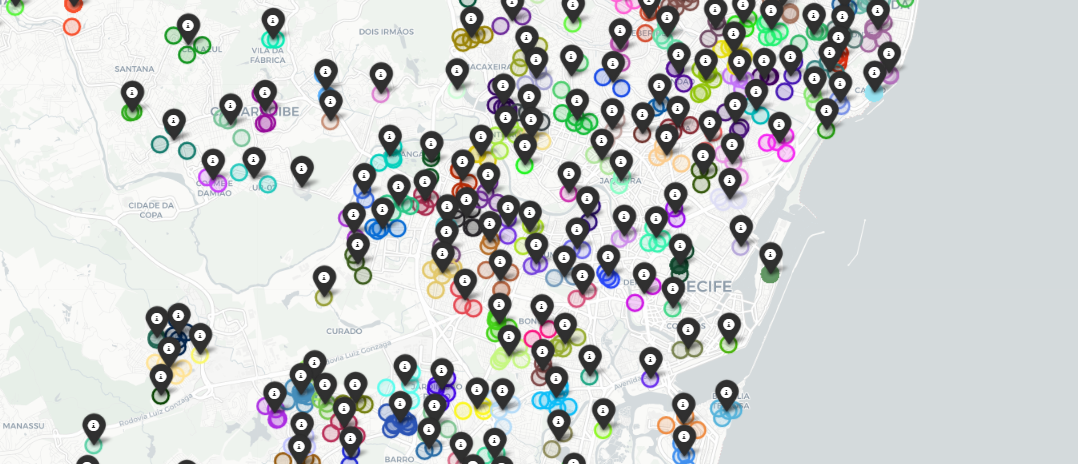